# A Replication of Models, Regimes, and Trend Following - Parts 1 & 2 

This notebook presents an **educational, step‑by‑step recreation** of [**JungleRock**](https://junglerock.com)'s *'Models, Regimes, and Trend Following - Parts 1 & 2'*

> **Disclaimer:**  
> All methods and analyses applied here are taken and *interpreted* from JungleRock's white papers.  
> All credit for the methodologies used goes to JungleRock.  
> Results may not be 100% identical, but strive to be as close as possible.

This notebook goes through the following processes:  
1. Pull Fama–French Market − RF data.  
2. Replicate *Time‑Series Momentum* (TSM) long‑only and long‑short portfolios.  
3. Estimate a two‑state **Markov Switching Model** (MSM) to classify *Bull* and *Bear* regimes.  
4. Compare “oracle” MSM regimes with the TSM rules (mis‑classification analysis).  
5. Explore volatility‑managed and majority‑vote extensions.

Feel free to run each cell and inspect intermediate outputs & plots.


## 1  — Setup & Imports

In [5]:
import os
import sys
import numpy as np
import pandas as pd

from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [6]:
notebook_path = os.path.abspath('')
repo_root = os.path.abspath(os.path.join(notebook_path, '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

if "google.colab" in sys.modules:
    if not os.path.exists("/content/models-regimes-trend"):
        !git clone https://github.com/internQuant/models-regimes-trend.git
    sys.path.insert(0, "/content/models-regimes-trend")

# Project‑specific helpers
from utils.data import *
from utils.misc import *
from utils.plots import *
from utils.transforms import *

## 2  — Data Ingestion  
We fetch **Fama–French Market minus Risk‑Free** returns using a small helper
(`FFScraper`).  Both **monthly** and **daily** series are required later for
volatility‑managed strategies.

This class provides access to Pofessor Kenneth French's data library


In [7]:
data_source = FFScraper()

monthly_returns = (
    data_source
    .monthly_data['mkt-rf']['1943':'2023-07']
    .copy()
    .squeeze()
    .rename('Buy and Hold')
)

daily_returns = (
    data_source
    .daily_data['mkt-rf']['1942':'2023-07']
    .copy()
    .squeeze()
    .rename('Buy and Hold Daily')
)

monthly_returns.head(), daily_returns.head()

(date
 1943-01-01    0.0713
 1943-02-01    0.0615
 1943-03-01    0.0601
 1943-04-01    0.0081
 1943-05-01    0.0574
 Name: Buy and Hold, dtype: float64,
 date
 1942-01-02    0.0187
 1942-01-03    0.0119
 1942-01-05    0.0100
 1942-01-06   -0.0040
 1942-01-07   -0.0066
 Name: Buy and Hold Daily, dtype: float64)

## 3  — Time‑Series Momentum (TSM) Strategy  
We build **long‑only** and **long‑short** TSM portfolios via `MonthlyTSMEngine`,
then compare their annualised Sharpe ratios to a simple *Buy‑and‑Hold*.

Feel free to explore the `MonthlyTSMEngine` class in the `transforms.py` module, it does all the heavy lifting here.


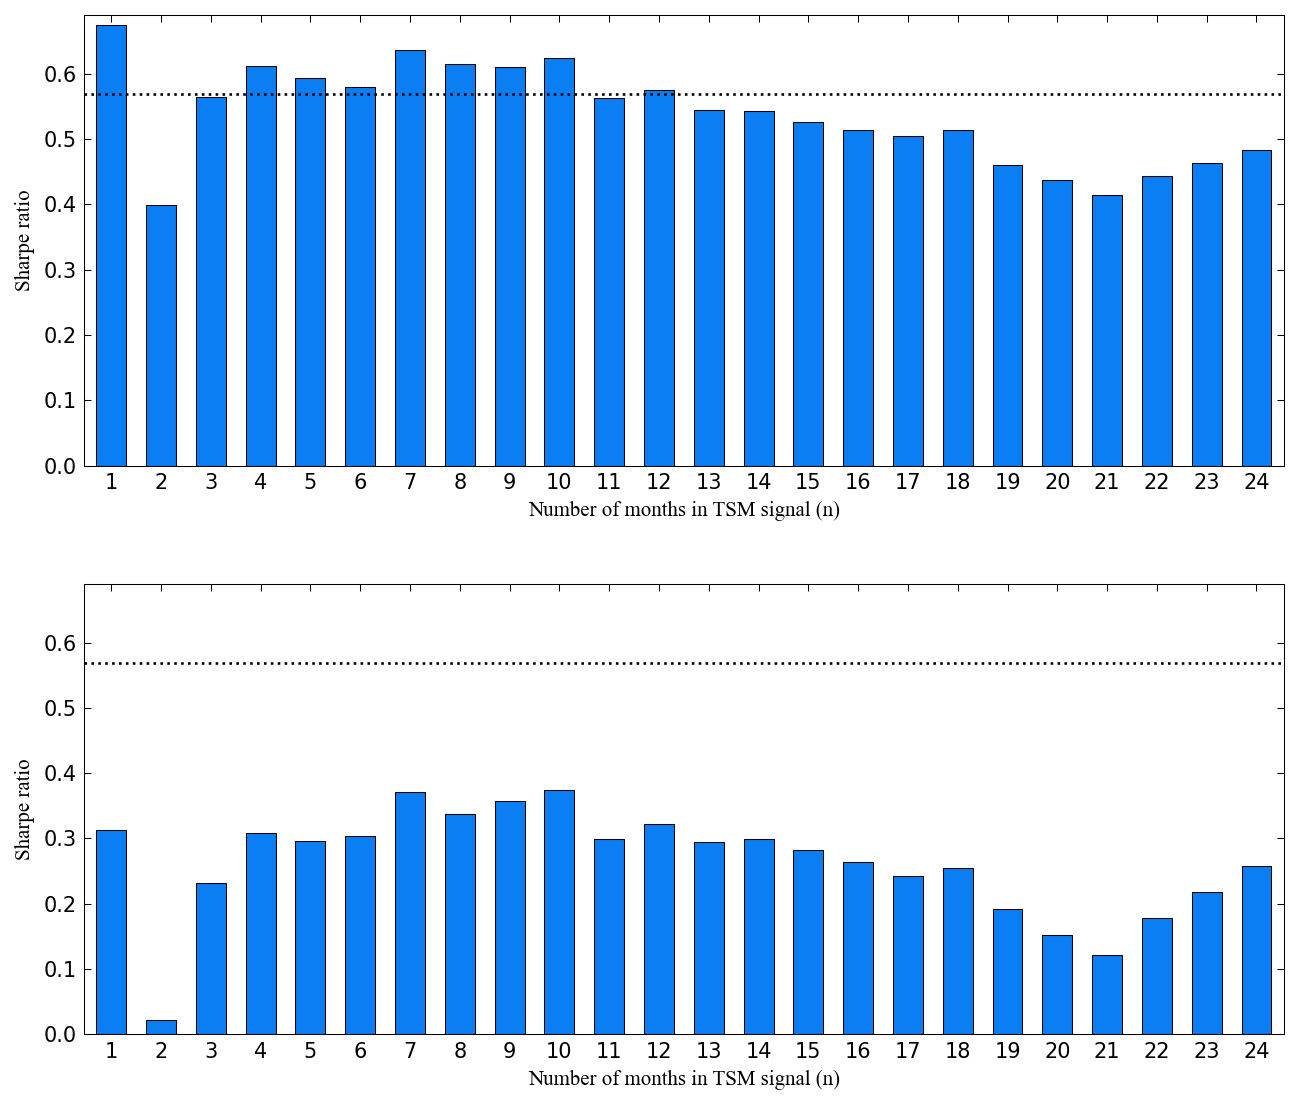

In [ ]:
TSME = TSMEngine(monthly_returns)
TSME_S = TSME.signals.copy().replace(0, np.nan)  # helper for later sections

lo_sharpe = m_sharpe(TSME.long_only_returns)
ls_sharpe = m_sharpe(TSME.long_short_returns)
bh_sharpe = m_sharpe(monthly_returns).item()  # scalar

plot_sharpes([lo_sharpe, ls_sharpe], bh_sharpe)

## 4  — Markov Switching Model (MSM)  
We fit a **two‑state Markov‑switching regression** with:  

* Switching means (trend `'c'`) -- Bull has positive mean, Bear has negative mean
* Switching variances (`switching_variance=True`) -- Bull has smaller variance

From the fitted model we:  

1. Extract parameter estimates & regime statistics.  
2. Obtain smoothed regime probabilities.  
3. Derive “oracle” *Bull* and *Bear* monthly return series.


In [ ]:
# Fit the model
model = MarkovRegression(
    monthly_returns,
    k_regimes=2,
    trend='c',
    switching_variance=True
)
result = model.fit()

# Identify regimes & probabilities
regimes_stats   = identify_2_regimes(result.params)
smoothed_probs  = result.smoothed_marginal_probabilities
regime_assignments = smoothed_probs.idxmax(axis=1)   # most likely regime per month

# Split returns by regime
regimes_monthly_returns = pd.concat(
    [
        monthly_returns[regime_assignments == 0],
        monthly_returns[regime_assignments == 1]
    ],
    axis=1,
    keys=['Bull', 'Bear']
)


c:\Users\rodri\miniconda3\envs\FinsScraps\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Regimes Statistics:

beta0: mean return in each regime
var: variance in each regime

& respective regime change probabilities

In [10]:
# Display summary statistics
display(pd.DataFrame(regimes_stats))

,bull,bear
beta0,0.0125,-0.0038
var,0.0010,0.0034
p11,0.9541,NaN
p12,0.0459,NaN
p22,NaN,0.9074
p21,NaN,0.0926


### Performance metrics in each regime against buy and hold

The result obtained in this replication has classified 4 months more as bear months than the result observed in the original White Paper

In [11]:
display(compute_MSM_metrics(pd.concat([monthly_returns, regimes_monthly_returns], axis=1)))

,Buy and Hold,Bull,Bear
Annual excess return (%),8.5,14.9,-7.4
Volatility (%),14.9,10.6,21.6
Sharpe ratio,0.6,1.4,-0.3
% positive months,61.0,68.0,44.0
Number of months,967.0,688.0,279.0
Max Drawdown (%),-55.7,-21.5,-93.5


### Monthly Excess Returns, Bull Regime Probability & Cumulative Return plots

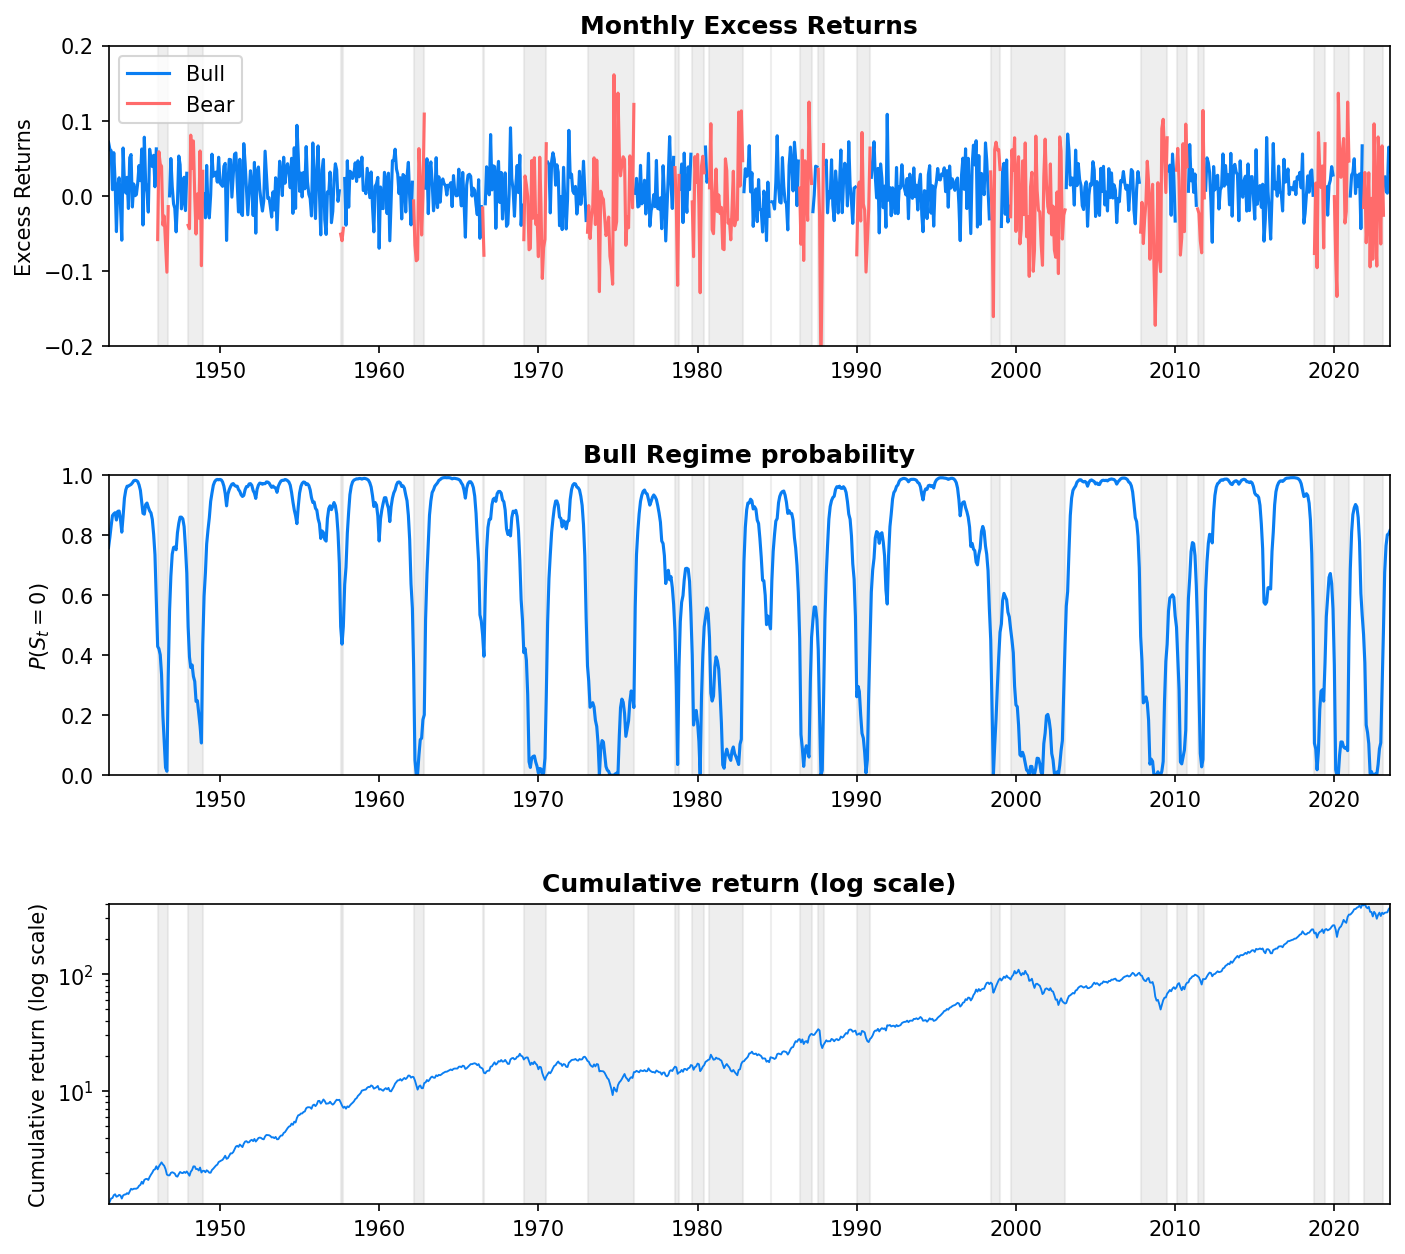

In [12]:
MSM_triple_plot(
    regimes_monthly_returns,
    smoothed_probs,
    regime_assignments,
    monthly_returns
)

## 5  — MSM Autocorrelation Diagnostics  
Theoretical ACF implied by the MSM is compared with the sample ACF of the
observed market returns.


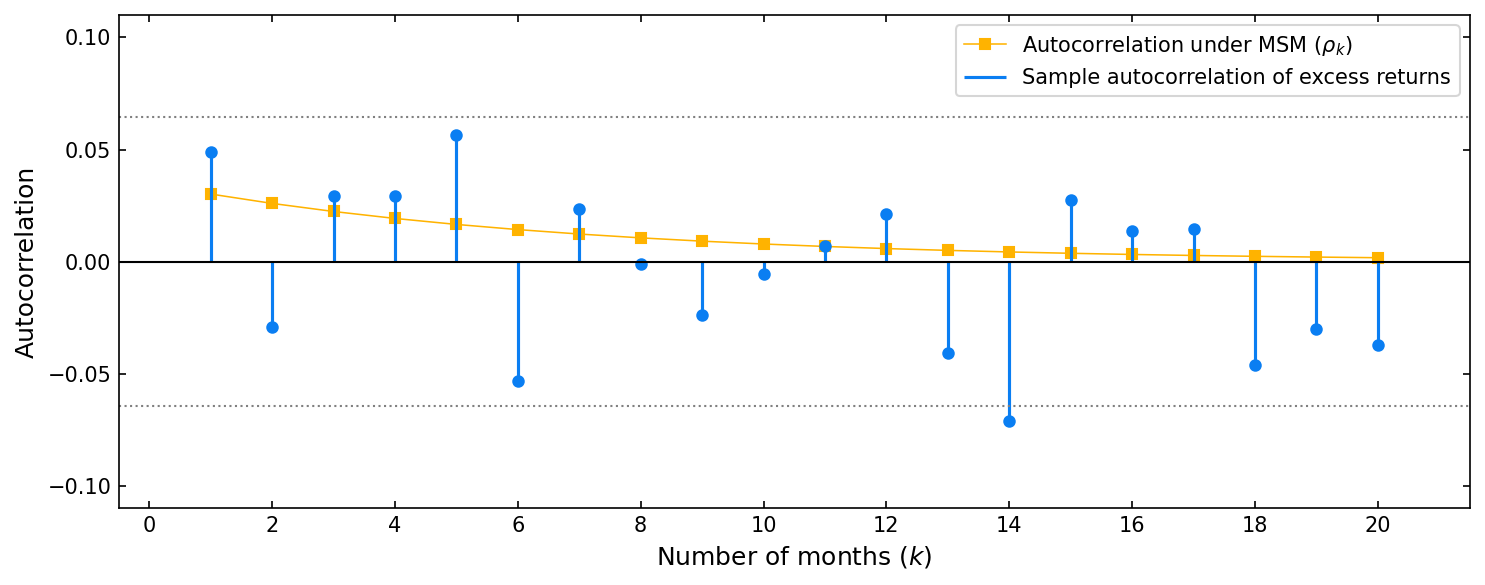

In [13]:
mu1 = regimes_stats['bull']['beta0']
mu2 = regimes_stats['bear']['beta0']
p11 = regimes_stats['bull']['p11']
p22 = regimes_stats['bear']['p22']

k_arr  = np.arange(1, 21)
msm_ar = pd.Series(compute_msm_ac(k_arr, mu1, mu2, p11, p22), index=k_arr)

plot_msm_ac(monthly_returns, msm_ar)


# Part II
## 6  — Strategy Comparison (Oracle vs. Buy‑and‑Hold)  
Using the **oracle** regime knowledge we build:  

* Long‑only “Bull”  
* Long‑short “Bull minus Bear”  

and compare against *Buy‑and‑Hold*.

In [14]:
all_ret = pd.concat([monthly_returns, regimes_monthly_returns], axis=1)
all_ret['LS'] = all_ret['Bull'].fillna(0) - all_ret['Bear'].fillna(0)

strats_rets = all_ret[['Buy and Hold', 'LS', 'Bull']].fillna(0)
strats_rets.columns = ['Buy and Hold', 'Oracle Long-Short', 'Oracle Long-Only']

compute_MSM_metrics(strats_rets)


,Buy and Hold,Oracle Long-Short,Oracle Long-Only
Annual excess return (%),8.5,12.8,10.6
Volatility (%),14.9,14.7,9.2
Sharpe ratio,0.6,0.9,1.2
% positive months,61.0,65.0,49.0
Number of months,967.0,967.0,967.0
Max Drawdown (%),-55.7,-46.1,-21.5


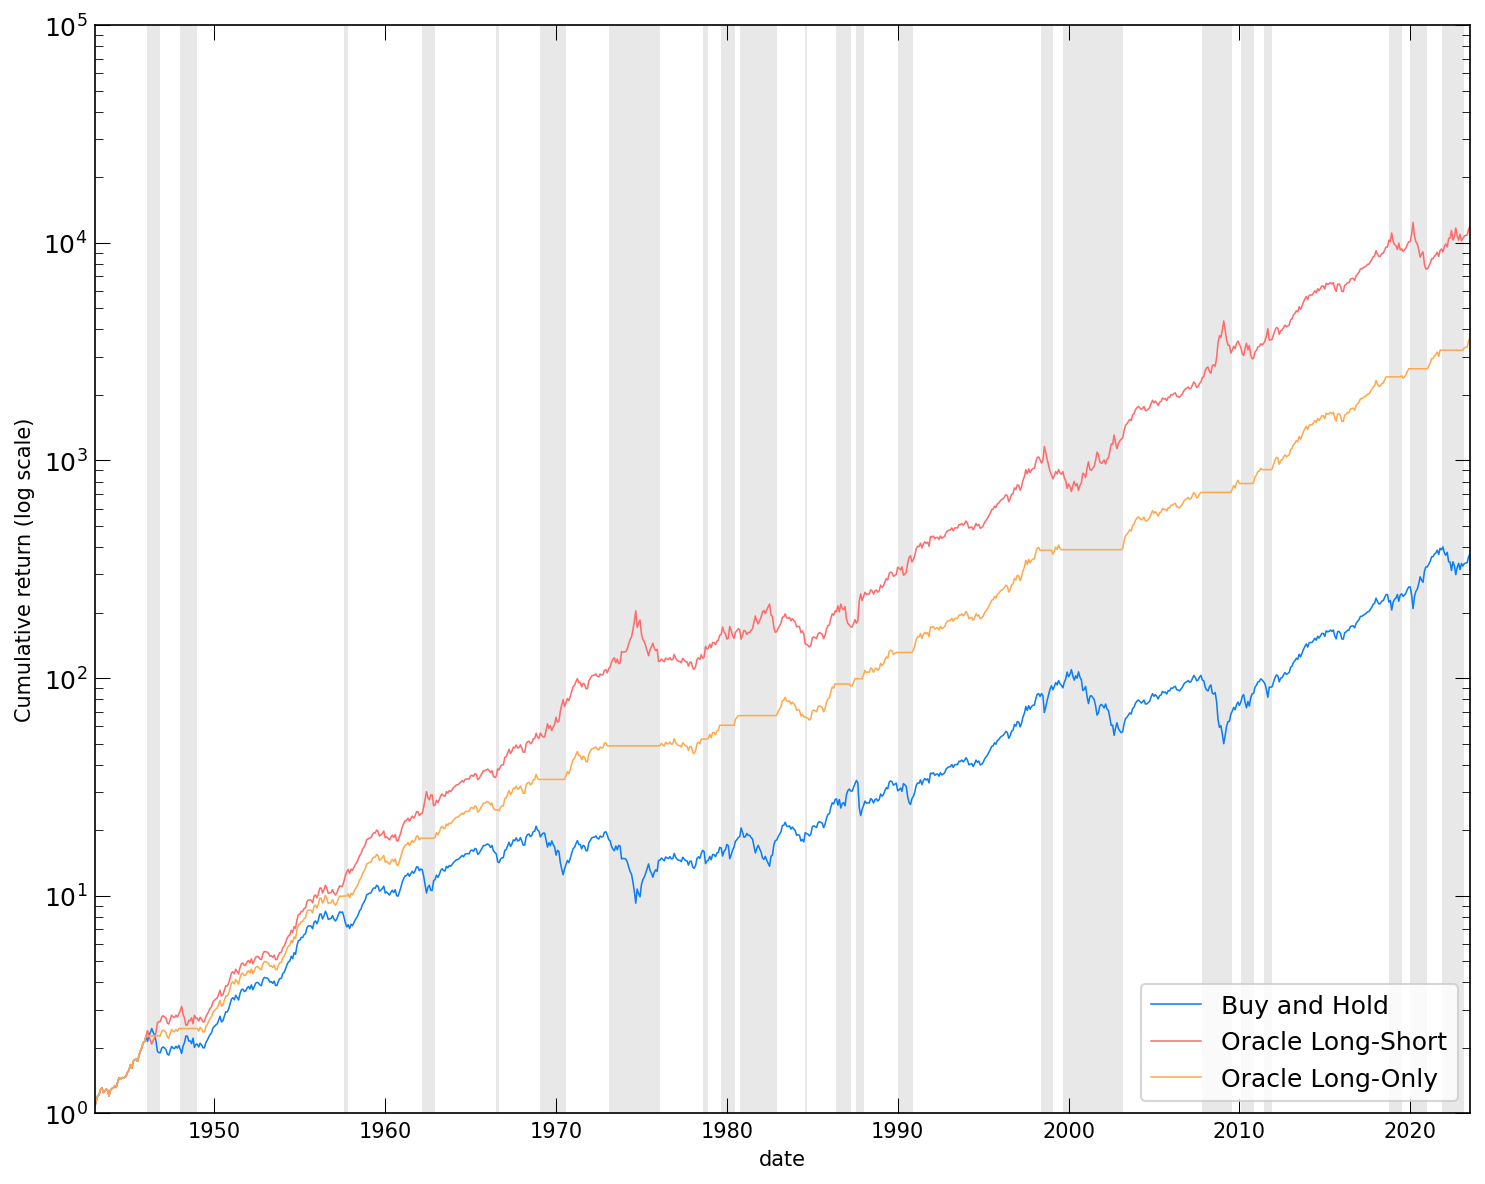

In [15]:
msm_cumulative_returns_plot(strats_rets, regime_assignments)

## 7  — TSM vs. Oracle: Mis‑classification Rates  
Next we compare TSM signals to MSM regimes and compute **False‑Positive (FP)**,
**False‑Negative (FN)** and overall error rates.

The TSM signals are classified into four categories:
1. True Positive (TP): TSM Bull and MSM Bull
2. True Negative (TN): TSM Bear and MSM Bear
3. False Positive (FP): TSM Bull and MSM Bear
4. False Negative (FN): TSM Bear and MSM Bull

The classification is done using the detect_tsm_classifications function

##### ***Results obtained here diverge quite a bit from the ones showed in the original white paper***


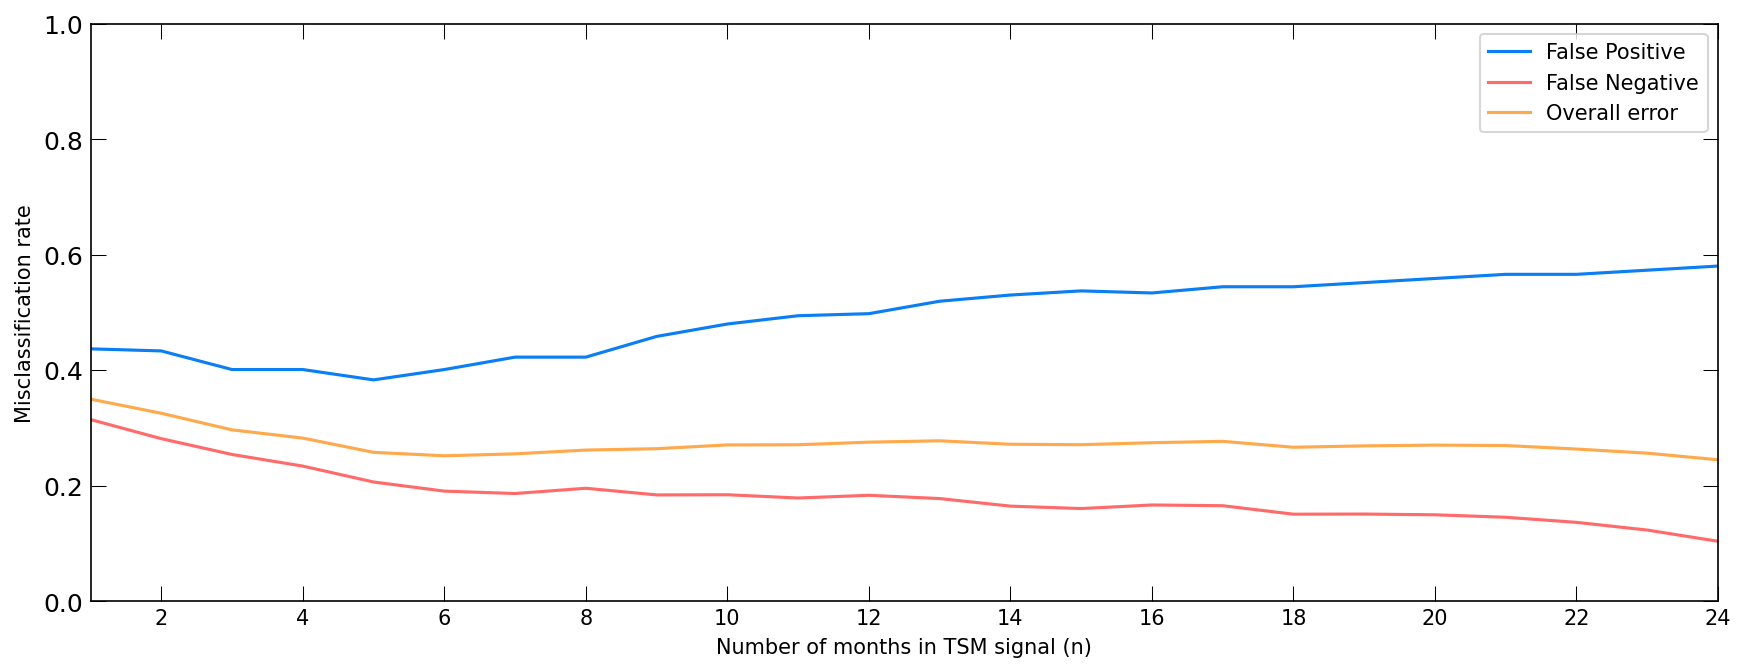

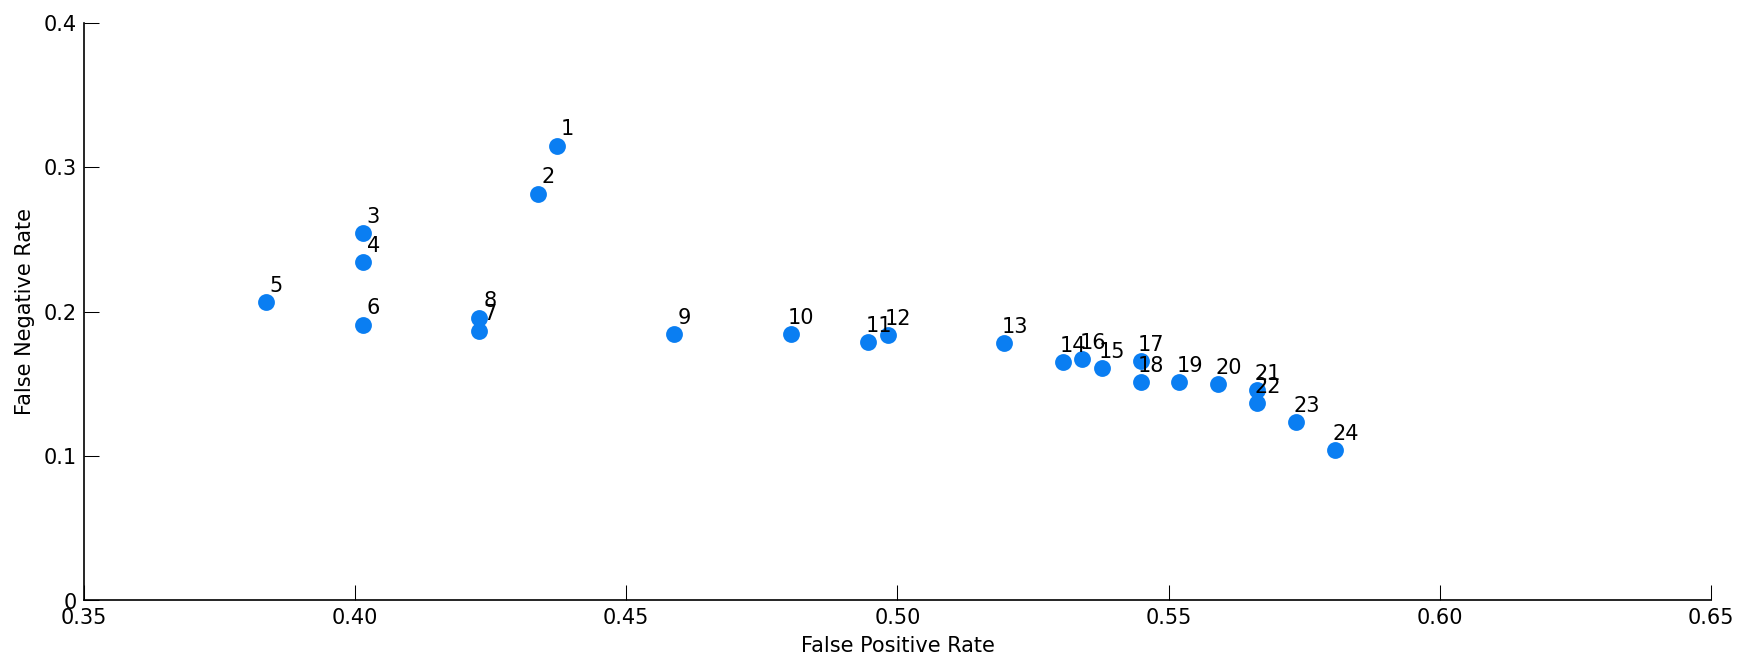

In [16]:
regime_signals = regime_assignments.replace({1: -1, 0: 1})
classi = detect_tsm_classifications(TSME_S, regime_signals)

tp = classi[classi == 1].count()
tn = classi[classi == 2].count()
fp = classi[classi == 3].count()
fn = classi[classi == 4].count()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
oer = (fp + fn) / classi.count()

errors = pd.concat(
    [fpr, fnr, oer],
    axis=1,
    keys=['False Positive', 'False Negative', 'Overall error']
)

plot_misclas(errors)
scatter_plot_misclas(errors)


## 8  — Volatility‑Managed Oracle Strategies  

Compute the volatility managed returns and metrics for the long-only and long-short strategies.

The volatility managed returns are computed using the `lovm_target_vol_scalar` and `lsvm_target_vol_scalars` functions.

These functions replicate the formulas described in the paper to estimate the volatility of the MSM

The target volatility is set to 0.1 (10%)
The volatility managed returns are then scaled to the target volatility 

In [17]:
sigma_1 = all_ret['Bull'].std() * np.sqrt(12)
sigma_2 = all_ret['Bear'].std() * np.sqrt(12)

d   = 2 - p11 - p22
pi1 = (1 - p22) / d
pi2 = (1 - p11) / d

target_vol = 0.1
lo_w        = lovm_target_vol_scalar(target_vol, sigma_1, pi1, pi2, mu1)
ls_lw, ls_sw = lsvm_target_vol_scalars(target_vol, sigma_1, sigma_2, pi1, pi2, mu1, mu2)

lovm = all_ret['Bull'].fillna(0) * lo_w
lovm = lovm * target_vol / (lovm.std() * np.sqrt(12))

lsvm = all_ret['Bull'].fillna(0) * ls_lw + all_ret['Bear'].fillna(0) * ls_sw
lsvm = lsvm * target_vol / (lsvm.std() * np.sqrt(12))

vm_rets = pd.concat(
      [lovm, lsvm],
      axis=1,
      keys=['Oracle Long-Only (volatility managed)',
      'Oracle Long-Short (volatility managed)']
)

compute_MSM_metrics(pd.concat([strats_rets, vm_rets], axis=1))


,Buy and Hold,Oracle Long-Short,Oracle Long-Only,Oracle Long-Only (volatility managed),Oracle Long-Short (volatility managed)
Annual excess return (%),8.5,12.8,10.6,11.6,10.9
Volatility (%),14.9,14.7,9.2,10.0,10.0
Sharpe ratio,0.6,0.9,1.2,1.2,1.1
% positive months,61.0,65.0,49.0,49.0,65.0
Number of months,967.0,967.0,967.0,967.0,967.0
Max Drawdown (%),-55.7,-46.1,-21.5,-23.3,-26.7


## 9  — Majority‑Vote & Volatility‑Managed TSM  
We blend the signals of multiple TSM lookbacks (majority vote) and optionally
apply volatility targeting using **daily** data.

*Results obtained here are worse in general compared to the original paper, the volatility managed variants outperform their counterparts, but the majority vote approach is not far better than some of the Long-Short volatility managed strategies.*


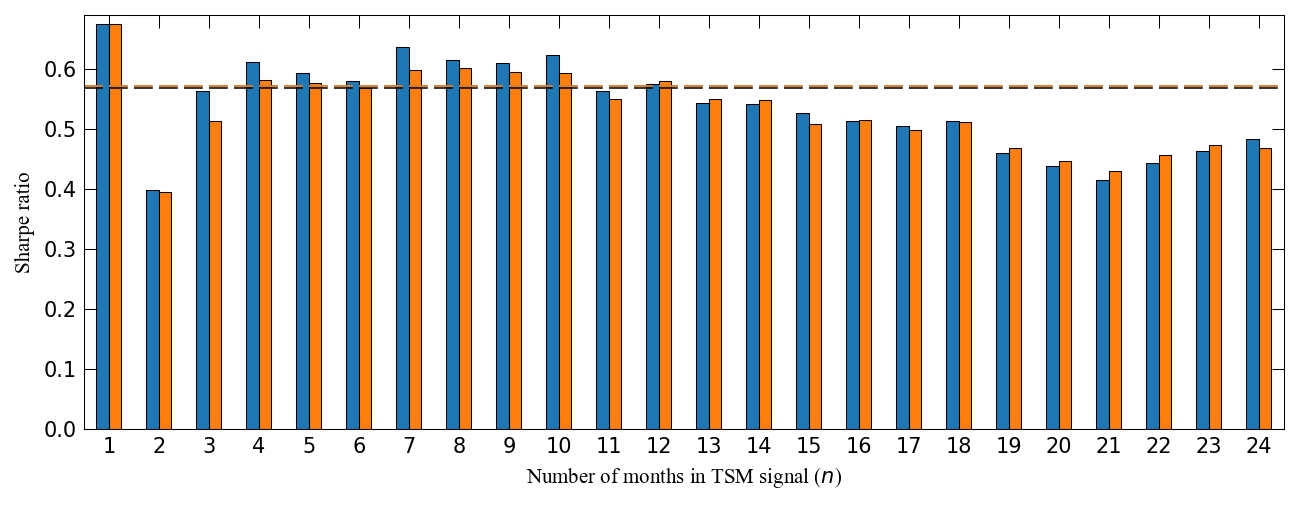

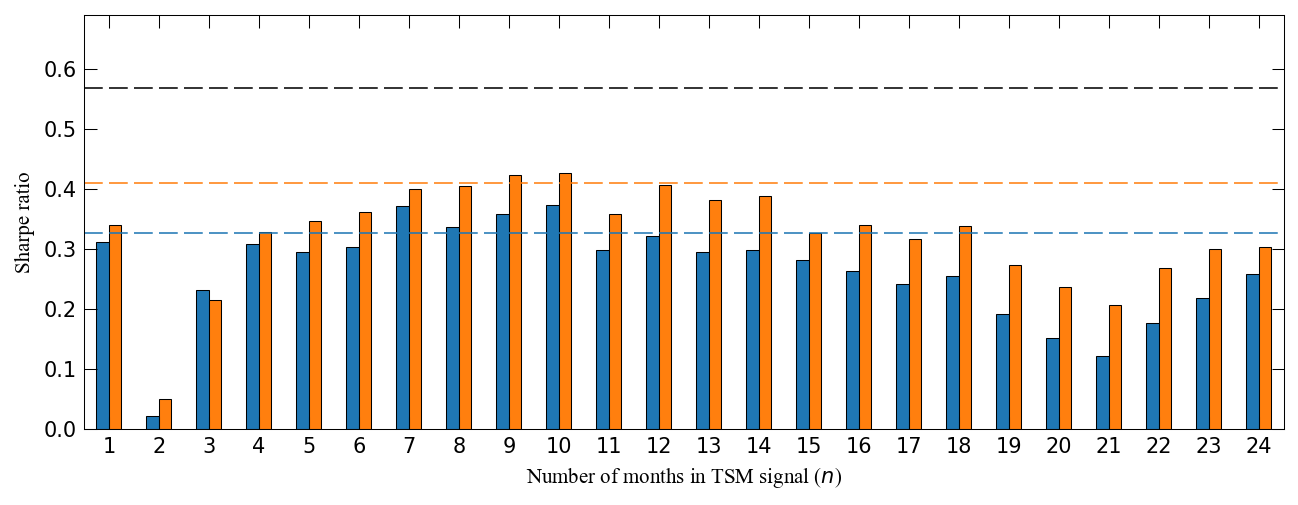

In [18]:
positive_tsm_signals = TSME_S.replace(-1, 0).sum(axis=1)
signal_count = TSME_S.count(axis=1)

maj_vote_cond = (positive_tsm_signals >= signal_count / 2).astype(int)

# Majority‑vote raw returns
lo_maj_vote = monthly_returns * maj_vote_cond
ls_maj_vote = monthly_returns * maj_vote_cond.replace(0, -1)

# Majority‑vote volatility managed
rolling_252_std = daily_returns.rolling(252).std().dropna()
rolling_252_std = (
    rolling_252_std.groupby(pd.Grouper(freq='ME')).last()
    .dropna()
    .shift(1)
)
rolling_252_std.index = rolling_252_std.index.map(lambda x: x.replace(day=1))
vol_scalar = 0.1 / (rolling_252_std * np.sqrt(252))

lo_maj_vote_vm = lo_maj_vote * vol_scalar
ls_maj_vote_vm = ls_maj_vote * vol_scalar

# Sharpe comparisons
bh_sharpe        = m_sharpe(monthly_returns).item()
lo_sharpe_mv     = m_sharpe(lo_maj_vote)
ls_sharpe_mv     = m_sharpe(ls_maj_vote)
lo_sharpe_mv_vm  = m_sharpe(lo_maj_vote_vm)
ls_sharpe_mv_vm  = m_sharpe(ls_maj_vote_vm)
tsm_lovm_sharpe  = m_sharpe(TSME.long_only_returns.mul(vol_scalar, axis=0))
tsm_lsvm_sharpe  = m_sharpe(TSME.long_short_returns.mul(vol_scalar, axis=0))

long_only_sharpes  = pd.concat([lo_sharpe, tsm_lovm_sharpe], axis=1)
long_short_sharpes = pd.concat([ls_sharpe, tsm_lsvm_sharpe], axis=1)

plot_sharpes_df(
    long_only_sharpes,
    {
        "Buy and Hold": bh_sharpe,
        "Majority Vote": lo_sharpe_mv,
        "Majority Vote Volatility Managed": lo_sharpe_mv_vm,
    }
)

plot_sharpes_df(
    long_short_sharpes,
    {
        "Buy and Hold": bh_sharpe,
        "Majority Vote": ls_sharpe_mv,
        "Majority Vote Volatility Managed": ls_sharpe_mv_vm,
    }
)


## 10  — Wrap‑Up

This basically wraps up the core of the first two parts to an acceptable degree of fidelity in results.

Thank you for checking this notebook out. Feel free to reach out to talk about any doubts, critiques, suggestions.